In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
csv_path = '/content/drive/MyDrive/FCN/data.csv'

In [ ]:
import pandas as pd
df = pd.read_csv(csv_path)
print(df.columns)


Index(['Unnamed: 0', 'ip', 'time', 'op', 'target', 'http', 'status',
       'body_bytes', 'request_length', 'request_time',
       'upstream_response_time', 'upstream_header_time', 'cache', 'http_refer',
       'http_user_agent', 'server_name', 'http_host', 'scheme', 'cid',
       'continent', 'country', 'regions', 'lat', 'long'],
      dtype='object')


LRU (size=10):   0%|          | 0/195859 [00:00<?, ?it/s]

LFU (size=10):   0%|          | 0/195859 [00:00<?, ?it/s]

ARC (size=10):   0%|          | 0/195859 [00:00<?, ?it/s]

TwoLevel (size=10):   0%|          | 0/195859 [00:00<?, ?it/s]

Hybrid (size=10):   0%|          | 0/195859 [00:00<?, ?it/s]

LRU (size=100):   0%|          | 0/195859 [00:00<?, ?it/s]

LFU (size=100):   0%|          | 0/195859 [00:00<?, ?it/s]

ARC (size=100):   0%|          | 0/195859 [00:00<?, ?it/s]

TwoLevel (size=100):   0%|          | 0/195859 [00:00<?, ?it/s]

Hybrid (size=100):   0%|          | 0/195859 [00:00<?, ?it/s]

LRU (size=500):   0%|          | 0/195859 [00:00<?, ?it/s]

LFU (size=500):   0%|          | 0/195859 [00:00<?, ?it/s]

ARC (size=500):   0%|          | 0/195859 [00:00<?, ?it/s]

TwoLevel (size=500):   0%|          | 0/195859 [00:00<?, ?it/s]

Hybrid (size=500):   0%|          | 0/195859 [00:00<?, ?it/s]

LRU (size=1000):   0%|          | 0/195859 [00:00<?, ?it/s]

LFU (size=1000):   0%|          | 0/195859 [00:00<?, ?it/s]

ARC (size=1000):   0%|          | 0/195859 [00:00<?, ?it/s]

TwoLevel (size=1000):   0%|          | 0/195859 [00:00<?, ?it/s]

Hybrid (size=1000):   0%|          | 0/195859 [00:00<?, ?it/s]

LRU (size=2000):   0%|          | 0/195859 [00:00<?, ?it/s]

LFU (size=2000):   0%|          | 0/195859 [00:00<?, ?it/s]

ARC (size=2000):   0%|          | 0/195859 [00:00<?, ?it/s]

TwoLevel (size=2000):   0%|          | 0/195859 [00:00<?, ?it/s]

Hybrid (size=2000):   0%|          | 0/195859 [00:00<?, ?it/s]

LRU (size=5000):   0%|          | 0/195859 [00:00<?, ?it/s]

LFU (size=5000):   0%|          | 0/195859 [00:00<?, ?it/s]

ARC (size=5000):   0%|          | 0/195859 [00:00<?, ?it/s]

TwoLevel (size=5000):   0%|          | 0/195859 [00:00<?, ?it/s]

Hybrid (size=5000):   0%|          | 0/195859 [00:00<?, ?it/s]

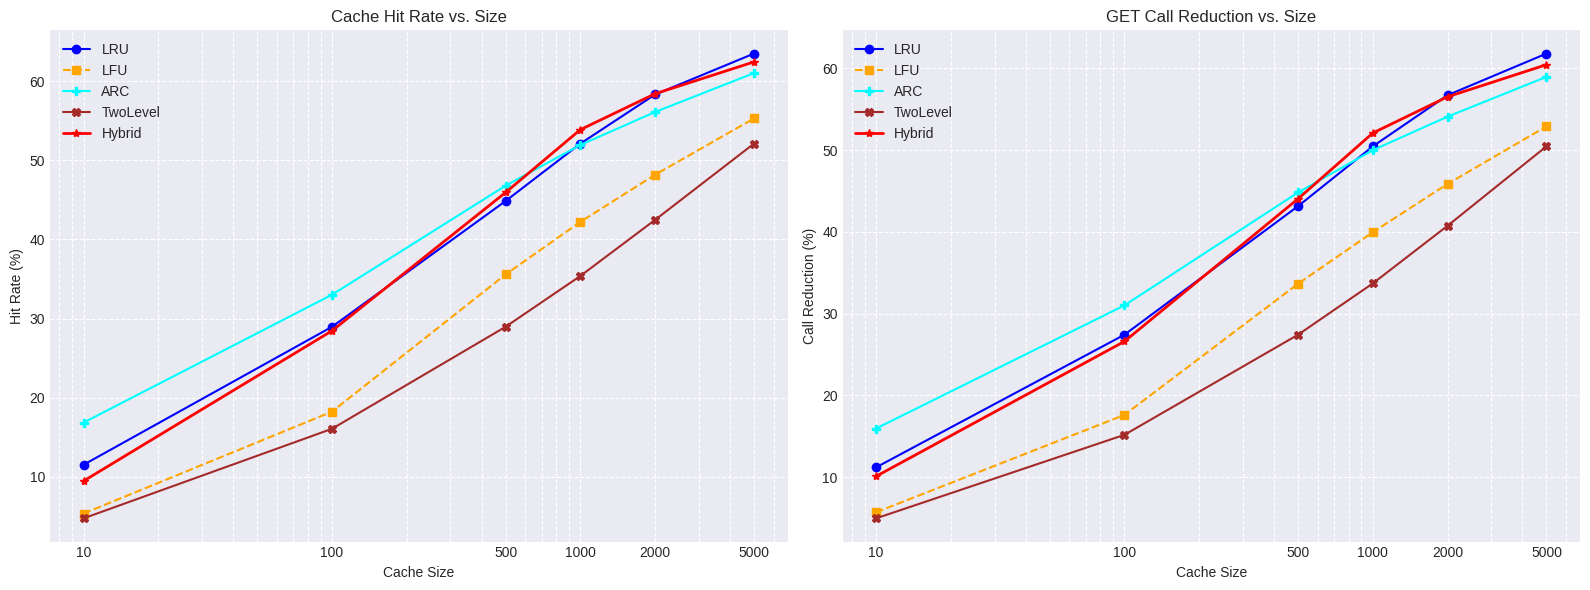


--- Extended Simulation Results ---
|   Cache Size |   LRU Hit Rate (%) |   LRU Reduction (%) |   LFU Hit Rate (%) |   LFU Reduction (%) |   ARC Hit Rate (%) |   ARC Reduction (%) |   TwoLevel Hit Rate (%) |   TwoLevel Reduction (%) |   Hybrid Hit Rate (%) |   Hybrid Reduction (%) |
|-------------:|-------------------:|--------------------:|-------------------:|--------------------:|-------------------:|--------------------:|------------------------:|-------------------------:|----------------------:|-----------------------:|
|           10 |              11.52 |               11.21 |               5.36 |                5.72 |              16.85 |               15.95 |                    4.75 |                     4.97 |                  9.47 |                  10.11 |
|          100 |              28.96 |               27.43 |              18.23 |               17.62 |              33.01 |               31.01 |                   16.06 |                    15.19 |                 28.4

In [ ]:
import pandas as pd
from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

class LRUCache:
    def __init__(self, capacity: int):
        self.cache = OrderedDict()
        self.capacity = capacity

    def get(self, key):
        if key not in self.cache:
            return -1
        self.cache.move_to_end(key)
        return 1

    def put(self, key):
        if key in self.cache:
            self.cache.move_to_end(key)
        else:
            if len(self.cache) >= self.capacity:
                self.cache.popitem(last=False)
            self.cache[key] = None

class LFUCache:
    class Node:
        def __init__(self, key, freq=1):
            self.key = key
            self.freq = freq

    def __init__(self, capacity: int):
        self.capacity = capacity
        self.key_to_node = {}
        self.freq_to_keys = defaultdict(OrderedDict)
        self.min_freq = 0

    def _update_freq(self, node):
        old_freq = node.freq
        # remove from old freq list
        del self.freq_to_keys[old_freq][node.key]
        if old_freq == self.min_freq and not self.freq_to_keys[old_freq]:
            self.min_freq += 1

        # bump frequency
        node.freq += 1
        new_freq = node.freq
        self.freq_to_keys[new_freq][node.key] = None
        self.freq_to_keys[new_freq].move_to_end(node.key)

    def get(self, key):
        if key not in self.key_to_node:
            return -1
        node = self.key_to_node[key]
        self._update_freq(node)
        return 1

    def put(self, key):
        if self.capacity == 0:
            return

        if key in self.key_to_node:
            self._update_freq(self.key_to_node[key])
        else:
            # need eviction?
            if len(self.key_to_node) >= self.capacity:
                # evict LRU among the min_freq list
                old_key, _ = self.freq_to_keys[self.min_freq].popitem(last=False)
                del self.key_to_node[old_key]

            # insert new node at freq=1
            new_node = self.Node(key)
            self.key_to_node[key] = new_node
            self.freq_to_keys[1][key] = None
            self.freq_to_keys[1].move_to_end(key)
            self.min_freq = 1

class RegionalCache:
    def __init__(self, total_capacity: int, regions: list):
        self.regions = regions
        self.num_regions = len(regions)
        self.per_region_capacity = max(1, total_capacity // self.num_regions) if self.num_regions else 0
        self.regional_caches = {
            region: LRUCache(self.per_region_capacity) for region in regions
        }

    def get(self, region, key):
        if region in self.regional_caches:
            return self.regional_caches[region].get(key)
        return -1

    def put(self, region, key):
        if region in self.regional_caches:
            self.regional_caches[region].put(key)



class ARCache:

    def __init__(self, capacity: int):
        self.capacity = capacity

        # Initialize the lists as OrderedDicts for O(1) access
        self.t1 = OrderedDict()
        self.t2 = OrderedDict()
        self.b1 = OrderedDict()
        self.b2 = OrderedDict()

        # p is the adaptive parameter that controls the balance
        # between T1 (recent) and T2 (frequent)
        self.p = 0

        # The ghost caches can be larger to track more history
        self.ghost_size = capacity

    def _replace(self, key):
        # If T1 is not empty and either B2 hit or T1 size > p
        if self.t1 and (key in self.b2 or len(self.t1) > self.p):
            # Evict LRU from T1
            lru_key, _ = self.t1.popitem(last=False)
            # Add to B1 ghost cache
            self.b1[lru_key] = None
            if len(self.b1) > self.ghost_size:
                self.b1.popitem(last=False)
        else:
            # Evict LRU from T2
            lru_key, _ = self.t2.popitem(last=False)
            # Add to B2 ghost cache
            self.b2[lru_key] = None
            if len(self.b2) > self.ghost_size:
                self.b2.popitem(last=False)

    def get(self, key):
        if key in self.t1:
            # Hit in T1 (recent), move to T2 (frequent)
            self.t1.move_to_end(key)
            val = self.t1.pop(key)
            self.t2[key] = val
            return 1
        elif key in self.t2:
            # Hit in T2 (already frequent), move to end for LRU tracking
            self.t2.move_to_end(key)
            return 1

        # Cache miss
        return -1

    def put(self, key):
        # Case 0: Already in cache (handled in get)
        if key in self.t1 or key in self.t2:
            return

        # Case 1: B1 hit - adjust p and load into T2
        if key in self.b1:
            delta = min(1, len(self.b2) / max(1, len(self.b1)))
            self.p = min(self.capacity, self.p + delta)
            del self.b1[key]
            self.t2[key] = None
            if len(self.t1) + len(self.t2) > self.capacity:
                self._replace(key)

        # Case 2: B2 hit - adjust p and load into T2
        elif key in self.b2:
            delta = min(1, len(self.b1) / max(1, len(self.b2)))
            self.p = max(0, self.p - delta)

            del self.b2[key]
            self.t2[key] = None

            if len(self.t1) + len(self.t2) > self.capacity:
                self._replace(key)

        # Case 3: New item not in any list
        else:

            l1 = len(self.t1) + len(self.b1)
            l2 = len(self.t2) + len(self.b2)
            if l1 == self.capacity:
                if len(self.t1) < self.capacity:
                    self.b1.popitem(last=False)
                    self.t1[key] = None
                else:
                    # T1 is full, evict LRU from T1
                    lru_key, _ = self.t1.popitem(last=False)
                    self.t1[key] = None
            elif l1 < self.capacity and l1 + l2 >= self.capacity:
                if l1 + l2 == 2 * self.capacity:
                    self.b2.popitem(last=False)
                self.t1[key] = None
            else:
                self.t1[key] = None
            if len(self.t1) + len(self.t2) > self.capacity:
                self._replace(key)

class RegionalARCache:
    def __init__(self, total_capacity: int, regions: list):
        self.regions = regions
        self.num_regions = len(regions)
        self.per_region_capacity = max(1, total_capacity // self.num_regions) if self.num_regions else 0
        self.regional_caches = {
            region: ARCache(self.per_region_capacity) for region in regions
        }

    def get(self, region, key):
        if region in self.regional_caches:
            return self.regional_caches[region].get(key)
        return -1

    def put(self, region, key):
        if region in self.regional_caches:
            self.regional_caches[region].put(key)

class HybridCache:

    class CacheEntry:
        def __init__(self, key, region=None):
            self.key = key
            self.region = region
            self.freq = 1
            self.last_access = 0
            self.recency_score = 0.0

    def __init__(self, capacity: int, regions: list, lru_weight=0.5, window_size=1000, adapt_interval=100):
        self.total_capacity = capacity
        self.regions = regions
        self.lru_weight = lru_weight
        self.entries = {}
        self.access_count = 0
        self.window_size = window_size
        self.adapt_interval = adapt_interval
        self.region_stats = {region: {'hits': 0, 'misses': 0, 'capacity': 0} for region in regions}
        self.region_stats['global'] = {'hits': 0, 'misses': 0, 'capacity': capacity}
        self.ghost_cache_size = min(capacity // 2, 100)
        self.ghost_cache = OrderedDict()
        self._adapt_region_capacities()

    def _calculate_score(self, entry):
        recency = 1.0 - ((self.access_count - entry.last_access) / self.window_size)
        recency = max(0.0, min(1.0, recency))  # Clamp to [0,1]
        freq_factor = np.log(entry.freq + 1) / np.log(100)
        return (self.lru_weight * recency) + ((1 - self.lru_weight) * freq_factor)

    def _adapt_region_capacities(self):
        total_hits = sum(stats['hits'] for stats in self.region_stats.values())

        # If we don't have enough data yet, use equal distribution
        if total_hits < 100:
            per_region = max(1, self.total_capacity // (len(self.regions) + 1))
            for region in self.regions:
                self.region_stats[region]['capacity'] = per_region
            self.region_stats['global']['capacity'] = self.total_capacity - (per_region * len(self.regions))
            return

        # Calculate hit rates
        region_hit_rates = {}
        for region, stats in self.region_stats.items():
            total_requests = stats['hits'] + stats['misses']
            if total_requests > 0:
                region_hit_rates[region] = stats['hits'] / total_requests
            else:
                region_hit_rates[region] = 0.0
        total_score = sum(region_hit_rates[r] * (self.region_stats[r]['hits'] + self.region_stats[r]['misses'])
                          for r in self.region_stats.keys())
        min_capacity = max(1, self.total_capacity // (len(self.region_stats) * 10))
        remaining_capacity = self.total_capacity - (min_capacity * len(self.region_stats))

        # Distribute remaining capacity
        for region in self.region_stats:
            requests = self.region_stats[region]['hits'] + self.region_stats[region]['misses']
            if total_score > 0 and requests > 0:
                score = region_hit_rates[region] * requests / total_score
                self.region_stats[region]['capacity'] = min_capacity + int(remaining_capacity * score)
            else:
                self.region_stats[region]['capacity'] = min_capacity

    def _evict_one(self, region):
        region_entries = [e for e in self.entries.values() if e.region == region]
        if not region_entries:
            return

        # Update scores for all entries in this region
        for entry in region_entries:
            entry.recency_score = self._calculate_score(entry)

        # Find entry with lowest score
        evict_entry = min(region_entries, key=lambda e: e.recency_score)

        # Add to ghost cache before eviction
        self.ghost_cache[evict_entry.key] = (evict_entry.region, evict_entry.freq)
        if len(self.ghost_cache) > self.ghost_cache_size:
            self.ghost_cache.popitem(last=False)  # Remove oldest ghost entry

        # Remove from main cache
        del self.entries[evict_entry.key]

    def get(self, region, key):
        self.access_count += 1

        # Check if in main cache
        if key in self.entries:
            entry = self.entries[key]
            entry.freq += 1
            entry.last_access = self.access_count

            # Update region stats
            if entry.region == region:
                self.region_stats[region]['hits'] += 1
            else:
                self.region_stats[entry.region]['hits'] += 1

            return 1
        if key in self.ghost_cache:

            old_region, old_freq = self.ghost_cache[key]
            if old_region == region:
                self.region_stats[region]['misses'] += 1
            else:
                self.region_stats['global']['misses'] += 1
        else:
            # Complete miss
            self.region_stats[region]['misses'] += 1

        # Adapt region capacities periodically
        if self.access_count % self.adapt_interval == 0:
            self._adapt_region_capacities()

        return -1

    def put(self, region, key):
        # If already in cache, just update frequency and last access
        if key in self.entries:
            self.entries[key].freq += 1
            self.entries[key].last_access = self.access_count
            return

        # Check if we have capacity in this region
        region_entries = [e for e in self.entries.values() if e.region == region]
        region_capacity = self.region_stats[region]['capacity']

        # Choose region based on whether this is a ghost cache hit
        target_region = region
        initial_freq = 1

        if key in self.ghost_cache:
            old_region, old_freq = self.ghost_cache[key]
            # If it was recently evicted, restore with higher priority
            initial_freq = old_freq
            # Prioritize original region if it had good performance
            if old_region == region:
                target_region = region
            else:
                # Put in global pool if cross-region ghost hit
                target_region = 'global'

        # Ensure we don't exceed capacity
        if len(region_entries) >= region_capacity:
            self._evict_one(target_region)

        # Create new entry
        new_entry = self.CacheEntry(key, target_region)
        new_entry.freq = initial_freq
        new_entry.last_access = self.access_count
        self.entries[key] = new_entry


class RegionalLFUCache:
    """Regional cache that uses LFU instead of LRU"""
    def __init__(self, total_capacity: int, regions: list):
        self.regions = regions
        self.num_regions = len(regions)
        self.per_region_capacity = max(1, total_capacity // self.num_regions) if self.num_regions else 0
        self.regional_caches = {
            region: LFUCache(self.per_region_capacity) for region in regions
        }

    def get(self, region, key):
        if region in self.regional_caches:
            return self.regional_caches[region].get(key)
        return -1

    def put(self, region, key):
        if region in self.regional_caches:
            self.regional_caches[region].put(key)


class TwoLevelCache:

    def __init__(self, capacity: int, l1_ratio=0.2):
        self.total_capacity = capacity
        self.l1_capacity = max(1, int(capacity * l1_ratio))
        self.l2_capacity = capacity - self.l1_capacity

        self.l1_cache = LRUCache(self.l1_capacity)
        self.l2_cache = LFUCache(self.l2_capacity)

    def get(self, key):
        # Try L1 first
        res = self.l1_cache.get(key)
        if res == 1:
            return 1

        # Then L2
        res = self.l2_cache.get(key)
        if res == 1:
            # Promote to L1
            self.l1_cache.put(key)
            return 1

        return -1

    def put(self, key):
        # Add to L1
        self.l1_cache.put(key)

        # If it was evicted from L1, it will not be there after put
        if self.l1_cache.get(key) == -1:
            # Add to L2 if evicted from L1
            self.l2_cache.put(key)


def run_extended_simulation(df, baseline_calls, unique_countries, target_op):
    cache_sizes = [10, 100, 500, 1000, 2000, 5000]

    results = {
        'LRU':            {'hit_rate': [], 'miss_rate': [], 'reduction': []},
        'LFU':            {'hit_rate': [], 'miss_rate': [], 'reduction': []},
        'ARC':            {'hit_rate': [], 'miss_rate': [], 'reduction': []},
        'TwoLevel':       {'hit_rate': [], 'miss_rate': [], 'reduction': []},
        'Hybrid':         {'hit_rate': [], 'miss_rate': [], 'reduction': []},
    }

    for size in cache_sizes:
        # Original strategies
        for cache_type, cache_obj in [
            ('LRU', LRUCache(size)),
            ('LFU', LFUCache(size)),
            ('ARC', ARCache(size)),
            ('TwoLevel', TwoLevelCache(size)),
            ('Hybrid', HybridCache(size, unique_countries + ['global']))
        ]:
            if cache_type in ['Regional-LRU', 'Regional-LFU', 'Hybrid']:
                # Regional caches need special handling
                hr, mr, red = run_simulation(df, cache_obj, f"{cache_type} (size={size})", baseline_calls, unique_countries)
            else:
                hr, mr, red = run_simulation(df, cache_obj, f"{cache_type} (size={size})", baseline_calls)

            results[cache_type]['hit_rate'].append(hr)
            results[cache_type]['miss_rate'].append(mr)
            results[cache_type]['reduction'].append(red)

    plot_results(cache_sizes, results, target_op)

    return create_summary_table(cache_sizes, results)

def run_simulation(df, cache, name, baseline_calls, unique_countries=None):

    hits = misses = 0
    backend_calls = 0
    is_regional = isinstance(cache, (RegionalCache, RegionalLFUCache, HybridCache))
    is_hybrid = isinstance(cache, HybridCache)
    is_two_level = isinstance(cache, TwoLevelCache)

    for _, row in tqdm(df.iterrows(), total=len(df), desc=name, leave=False):
        cid = str(row['cid'])
        is_target = row['is_target_op']
        country = str(row['country']) if row['country_valid'] else None

        if is_regional:
            if country:
                if is_hybrid and country not in cache.regions:
                    # For hybrid, use 'global' for unknown regions
                    res = cache.get('global', cid)
                else:
                    res = cache.get(country, cid)

                if res == 1:
                    hits += 1
                else:
                    misses += 1
                    if is_target:
                        backend_calls += 1

                    if is_hybrid and country not in cache.regions:
                        cache.put('global', cid)
                    else:
                        cache.put(country, cid)
            else:
                misses += 1
                if is_target:
                    backend_calls += 1
                # For hybrid, use global bucket for unknown countries
                if is_hybrid:
                    cache.put('global', cid)
        elif is_two_level:
            res = cache.get(cid)
            if res == 1:
                hits += 1
            else:
                misses += 1
                if is_target:
                    backend_calls += 1
                cache.put(cid)
        else:
            res = cache.get(cid)
            if res == 1:
                hits += 1
            else:
                misses += 1
                if is_target:
                    backend_calls += 1
                cache.put(cid)

    total = hits + misses
    hit_rate = hits/total*100 if total else 0
    miss_rate = misses/total*100 if total else 0

    # Calculate reduction as percentage of backend calls saved
    reduction = 0
    if baseline_calls > 0:
        reduction = ((baseline_calls - backend_calls) / baseline_calls) * 100

    return hit_rate, miss_rate, max(0, min(reduction, 100))

def plot_results(cache_sizes, results, target_op):
    """Plot the results of all cache strategies"""
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Line styles and markers for different strategies
    styles = {
        'LRU':          {'marker': 'o', 'linestyle': '-', 'color': 'blue'},
        'LFU':          {'marker': 's', 'linestyle': '--', 'color': 'orange'},
        'ARC':          {'marker': 'P', 'linestyle': '-', 'color': 'cyan', 'linewidth': 1.5},
        'TwoLevel':     {'marker': 'X', 'linestyle': '-', 'color': 'brown'},
        'Hybrid':       {'marker': '*', 'linestyle': '-', 'color': 'red', 'linewidth': 2}
    }

    # Hit Rate
    for cache_type, style in styles.items():
        if cache_type in results:
            ax1.plot(cache_sizes, results[cache_type]['hit_rate'],
                     label=cache_type, **style)

    ax1.set_xscale('log')
    ax1.set_xticks(cache_sizes)
    ax1.set_xticklabels(cache_sizes)
    ax1.set_xlabel('Cache Size')
    ax1.set_ylabel('Hit Rate (%)')
    ax1.set_title('Cache Hit Rate vs. Size')
    ax1.legend()
    ax1.grid(True, which='both', ls='--')

    # Reduction
    for cache_type, style in styles.items():
        if cache_type in results:
            ax2.plot(cache_sizes, results[cache_type]['reduction'],
                     label=cache_type, **style)

    ax2.set_xscale('log')
    ax2.set_xticks(cache_sizes)
    ax2.set_xticklabels(cache_sizes)
    ax2.set_xlabel('Cache Size')
    ax2.set_ylabel('Call Reduction (%)')
    ax2.set_title(f'{target_op} Call Reduction vs. Size')
    ax2.legend()
    ax2.grid(True, which='both', ls='--')

    plt.tight_layout()
    plt.show()

def create_summary_table(cache_sizes, results):
    """Create a summary table of all results"""
    data = {'Cache Size': cache_sizes}

    for cache_type in results:
        data[f'{cache_type} Hit Rate (%)'] = results[cache_type]['hit_rate']
        data[f'{cache_type} Reduction (%)'] = results[cache_type]['reduction']

    summary = pd.DataFrame(data)
    return summary.round(2)



def main(df, baseline_calls, unique_countries, target_op):
    """Run simulation with all cache strategies"""
    # First, run simulation with existing and new strategies
    summary = run_extended_simulation(df, baseline_calls, unique_countries, target_op)

    print("\n--- Extended Simulation Results ---")
    print(summary.to_markdown(index=False))

def get_best_strategy(summary):
    """Determine the best strategy based on average reduction"""
    strategies = [col.split(' ')[0] for col in summary.columns if 'Reduction' in col]
    avg_reductions = {}

    for strategy in strategies:
        col = f'{strategy} Reduction (%)'
        avg_reductions[strategy] = summary[col].mean()

    return max(avg_reductions.items(), key=lambda x: x[1])[0]

def tune_hybrid_parameters(df, baseline_calls, unique_countries, target_op):
    """Tune parameters for the hybrid cache"""
    print("\n--- Tuning Hybrid Cache Parameters ---")

    # Parameters to tune
    lru_weights = [0.2, 0.4, 0.6, 0.8]
    window_sizes = [500, 1000, 2000]

    # Fixed cache size
    cache_size = 500

    # Results container
    tuning_results = []

    for lru_w in lru_weights:
        for win_size in window_sizes:
            # Create hybrid cache with these parameters
            cache = HybridCache(
                cache_size,
                unique_countries + ['global'],
                lru_weight=lru_w,
                window_size=win_size
            )

            # Run simulation
            hr, mr, red = run_simulation(
                df, cache, f"Hybrid (w={lru_w}, win={win_size})",
                baseline_calls, unique_countries
            )

            tuning_results.append({
                'LRU Weight': lru_w,
                'Window Size': win_size,
                'Hit Rate (%)': hr,
                'Reduction (%)': red
            })

    # Convert to DataFrame and sort by reduction
    tuning_df = pd.DataFrame(tuning_results)
    tuning_df = tuning_df.sort_values('Reduction (%)', ascending=False)

    print("\nParameter tuning results (sorted by reduction):")
    print(tuning_df.to_markdown(index=False))

    # Get best parameters
    best_params = tuning_df.iloc[0]
    print(f"\nBest parameters for Hybrid cache:")
    print(f"  LRU Weight: {best_params['LRU Weight']}")
    print(f"  Window Size: {best_params['Window Size']}")
    print(f"  Resulting Hit Rate: {best_params['Hit Rate (%)']:.2f}%")
    print(f"  Resulting Reduction: {best_params['Reduction (%)']:.2f}%")

def tune_twolevel_parameters(df, baseline_calls, target_op):
    """Tune parameters for the two-level cache"""
    print("\n--- Tuning Two-Level Cache Parameters ---")

    # Parameters to tune
    l1_ratios = [0.1, 0.3, 0.5]

    # Fixed cache size
    cache_size = 500

    # Results container
    tuning_results = []

    for l1_ratio in l1_ratios:
        # Create two-level cache with this ratio
        cache = TwoLevelCache(cache_size, l1_ratio=l1_ratio)

        # Run simulation
        hr, mr, red = run_simulation(
            df, cache, f"TwoLevel (L1={l1_ratio})", baseline_calls
        )

        tuning_results.append({
            'L1 Ratio': l1_ratio,
            'Hit Rate (%)': hr,
            'Reduction (%)': red
        })

    # Convert to DataFrame and sort by reduction
    tuning_df = pd.DataFrame(tuning_results)
    tuning_df = tuning_df.sort_values('Reduction (%)', ascending=False)

    print("\nParameter tuning results (sorted by reduction):")
    print(tuning_df.to_markdown(index=False))

    # Get best parameters
    best_params = tuning_df.iloc[0]
    print(f"\nBest parameters for Two-Level cache:")
    print(f"  L1 Ratio: {best_params['L1 Ratio']}")
    print(f"  Resulting Hit Rate: {best_params['Hit Rate (%)']:.2f}%")
    print(f"  Resulting Reduction: {best_params['Reduction (%)']:.2f}%")

main(df_proc, baseline, countries, target_op)